# Sequence Models in Tensorflow

In this notebook, we'll build a very basic sequence model using a (not very) deep neural net. It should run on a semi-powerful laptop without GPU support, but no promises...

Helpful links:

* [Tensorflow 2.0 Docs](https://www.tensorflow.org/beta)
* [Seq2Seq in Tensorflow 2.0](https://machinetalk.org/2019/03/29/neural-machine-translation-with-attention-mechanism/)
* [Transformer in Tensorflow 2.0](https://machinetalk.org/2019/04/29/create-the-transformer-with-tensorflow-2-0/)

## Background

* Sequence models
* Seq2Seq
* Transformer

## Imports

Import core libraries and make sure tensorflow is working

In [44]:
# Standard lib
import itertools

# 3rd party libraries
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
assert tf.__version__.startswith('2.')

In [2]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-rc1
Eager mode:  True
GPU is NOT AVAILABLE


## CpG Island Model

Let's compare these sequence models to the CpG island HMM predictor from last week

Here's the sequence from last time:

In [3]:
seq = 'AGAACTGCTGACTGATAGATCGCGCGCCGCGCGCGCGGCATGCATCGATGCATGCGCAACTCGAATCGATTGACAGAAGACAATTATGACAATGCGCAGCAGCATTTATTACTACACATACGGTGCACTGCGCGCGCTCACTGCA'

In [8]:
seq_dict = {'A': 0, 'T': 1, 'G': 2, 'C': 3}

In [9]:
obs_seq = np.array([seq_dict[s] for s in seq])
obs_seq

array([0, 2, 0, 0, 3, 1, 2, 3, 1, 2, 0, 3, 1, 2, 0, 1, 0, 2, 0, 1, 3, 2,
       3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 0, 1, 2, 3, 0,
       1, 3, 2, 0, 1, 2, 3, 0, 1, 2, 3, 2, 3, 0, 0, 3, 1, 3, 2, 0, 0, 1,
       3, 2, 0, 1, 1, 2, 0, 3, 0, 2, 0, 0, 2, 0, 3, 0, 0, 1, 1, 0, 1, 2,
       0, 3, 0, 0, 1, 2, 3, 2, 3, 0, 2, 3, 0, 2, 3, 0, 1, 1, 1, 0, 1, 1,
       0, 3, 1, 0, 3, 0, 3, 0, 1, 0, 3, 2, 2, 1, 2, 3, 0, 3, 1, 2, 3, 2,
       3, 2, 3, 2, 3, 1, 3, 0, 3, 1, 2, 3, 0])

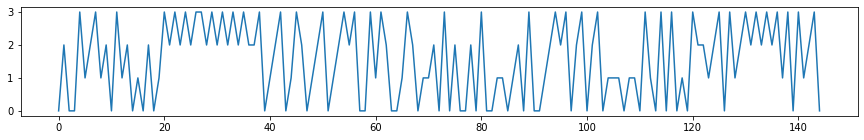

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(obs_seq);

Here's the HMM model from last time

In [12]:
emissions = np.ones((2, 4))
emissions[0, :] = 0.25
emissions[1, :2] = 0.1
emissions[1, 2:] = 0.4

# Make sure our emission matrix is a probability matrix
assert np.all(np.abs(np.sum(emissions, axis=1) - 1.0) < 1e-5)

emissions

array([[0.25, 0.25, 0.25, 0.25],
       [0.1 , 0.1 , 0.4 , 0.4 ]])

In [13]:
transitions = np.ones((2, 2))
transitions[0, 0] = 0.9
transitions[0, 1] = 0.1
transitions[1, 0] = 0.05
transitions[1, 1] = 0.95

# Make sure our transition matrix is a probability matrix
assert np.all(np.abs(np.sum(transitions, axis=1) - 1.0) < 1e-5)

transitions

array([[0.9 , 0.1 ],
       [0.05, 0.95]])

Use the HMM to predict the best states

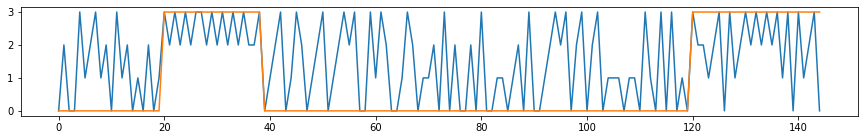

In [27]:
def viterbi(x, transmat, emissions):
    v_seq = np.zeros((len(x), len(transmat)))
    states = np.zeros((len(x), len(transmat)))
    best_states = np.zeros(len(x),  dtype=int)
    for i in range(len(v_seq)):
        if i == 0:
            v_seq[0] = (1/len(transmat)) * emissions[:,x[i]]
            v_seq[0] = np.log(v_seq[0])
            states[0] = np.zeros(len(transmat))
            continue
        p = v_seq[i-1] + np.log(transmat.T)
        states[i] =  np.argmax(p, axis=1)
        v_seq[i] =   np.log(emissions[:,x[i]]) + np.amax(p, axis = 1)
        
    best_states[-1] = np.argmax(v_seq[-1])
    
    for i in reversed(range(1, len(x))):
        best_states[i-1] = states[i][best_states[i]]
        
    return v_seq, states, best_states

v_seq, states, best_states = viterbi(obs_seq, transitions, emissions)

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(obs_seq)
ax.plot(best_states*3);

## Using the HMM to generate training data

Since the HMM is a generative model, let's use it to generate a training data set

In [29]:
def sample_hmm(x_len: int = 145):
    """ Sample the hidden markov model """
    emission_states = np.arange(emissions.shape[1])
    transition_states = np.arange(transitions.shape[1])

    # Guess initial state random
    states = [np.random.choice(transition_states, p=np.array([0.5, 0.5]))]
    values = []
    
    # Now step through and draw samples according to the model
    for i in range(x_len):
        cur_state = states[i]
        emission_prob = emissions[cur_state, :]
        transition_prob = transitions[cur_state, :]
        values.append(np.random.choice(emission_states, p=emission_prob))
        states.append(np.random.choice(transition_states, p=transition_prob))
    return np.array(states[:-1]), np.array(values)


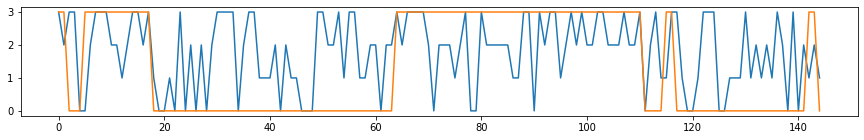

In [34]:
states, values = sample_hmm()

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(values)
ax.plot(states*3);

This does show a limitation of this simple HMM: it generates sequences that don't really look like real sequences. We could probably do better if our HMM was more tuned or had more complicated structure.

On the other hand, it provides a nice data set with clear ground truth, so lets just go forward with it.

### Generate samples

Generate 1000 samples and split them into train/test/validation

In [40]:
# Set the random seed here
np.random.seed(12345)

# Generate 1000 samples
x_data, y_data = [], []
for _ in range(1000):
    states, values = sample_hmm()
    x_data.append(values)
    y_data.append(states)

# Split into train/test/validation
x_train, y_train = x_data[:800], y_data[:800]
x_test, y_test = x_data[800:900], y_data[800:900]
x_valid, y_valid = x_data[900:], y_data[900:]

Do the samples in each bucket look similar?

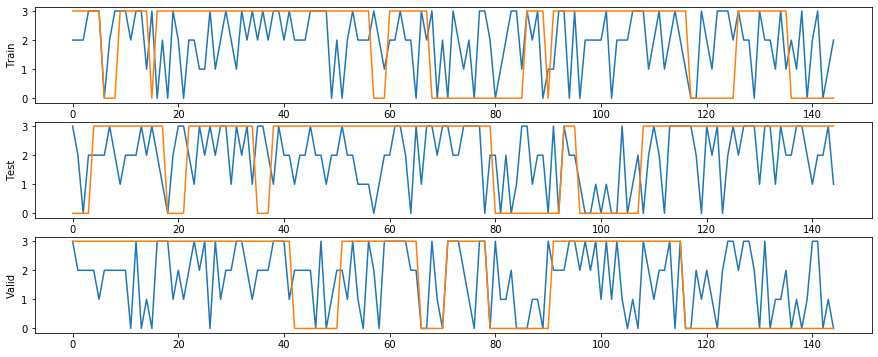

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 6))
ax1.plot(x_train[0])
ax1.plot(y_train[0]*3)
ax1.set_ylabel('Train')

ax2.plot(x_test[1])
ax2.plot(y_test[1]*3)
ax2.set_ylabel('Test')

ax3.plot(x_valid[2])
ax3.plot(y_valid[2]*3)
ax3.set_ylabel('Valid');

## Model 1: Convolutional Neural Net

Before diving into sequence models, lets look at how hard it would be to model this data with a simpler architecture: a Convolutional Neural Net.

First question, how wide are our islands, on average:

In [50]:
# Find the lengths of all the runs in the data
island_lengths = [sum(g) for y in y_train for b, g in itertools.groupby(y) if b == 1]

# zero-D Bar plot
print('Min length:    {:0.2f}'.format(np.min(island_lengths)))
print('Max length:    {:0.2f}'.format(np.max(island_lengths)))
print('Mean length:   {:0.2f}'.format(np.mean(island_lengths)))
print('Std length:    {:0.2f}'.format(np.std(island_lengths)))

Min length:    1.00
Max length:    133.00
Mean length:   17.72
Std length:    17.02


In [49]:
# zero-D Box plot
print('5%  length:    {:0.2f}'.format(np.percentile(island_lengths, 5)))
print('25% length:    {:0.2f}'.format(np.percentile(island_lengths, 25)))
print('Median length: {:0.2f}'.format(np.median(island_lengths)))
print('75% length:    {:0.2f}'.format(np.percentile(island_lengths, 75)))
print('95% length:    {:0.2f}'.format(np.percentile(island_lengths, 95)))

5%  length:    1.00
25% length:    6.00
Median length: 13.00
75% length:    24.00
95% length:    52.00


So, with a field of view of only 52 characters, we can cover 95% of all "CpG" islands. 

In [ ]:
model = tf.keras.Sequential([
    
])